In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from tensorflow.python.keras.optimizer_v2.adam import Adam
import seaborn as sns

In [2]:
from keras.backend import manual_variable_initialization

manual_variable_initialization(True)

# Used CSV Files in This Notebook Can Be Reached Via The Link Given Below
https://drive.google.com/drive/folders/1LJBghznfrr3SfxHZ8sUenAc6pdhb5vKK?usp=sharing

# READ DATASET

In [3]:
df = pd.read_csv('C:/Users/norma/Desktop/BİTİRME/BITIRME/Without_MCI_GSE_OrtakData_NormR.csv', sep = ";", decimal=",")
# Keeping only 2 classes which are AD and CTL
df = df[df.Class != 2]

In [4]:
features = df.drop('Class',axis=1)
labels_dr = 'C:/Users/norma/Desktop/BİTİRME/BITIRME/OneHotEncoded_Labels.csv'
labels_df = pd.read_csv(labels_dr, sep = ',')
labels = labels_df.iloc[:949,:2]

# PCA

In [5]:
n_components = 225
pca = PCA(n_components = n_components).fit(features)
principalComponents = pca.fit_transform(features)
columns = ['Pc' + str(i) for i in range(1,n_components+1)]
principalDf = pd.DataFrame(data = principalComponents
             , columns = columns)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(principalDf, labels, test_size= 0.22, random_state = 41)

In [7]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## MODEL

In [8]:
opt = tf.keras.optimizers.Adam(0.0001)

In [9]:
input_dim = principalDf.shape[1]

def build_model(optimizer=opt, init_mode='he_uniform'):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(64, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(128, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(128, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(256, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(256, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(512, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(512, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(256, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(256, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(64, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(64, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(32, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(32, kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(2, kernel_initializer=init_mode, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['categorical_accuracy'])

    return model

In [10]:
ckpt = keras.callbacks.ModelCheckpoint(
        filepath='C:/Users/norma/Desktop/BITIRME/Models/MLP/best_model.{epoch:02d}-{val_categorical_accuracy:.4f}.h5',
        monitor='val_categorical_accuracy', save_best_only=True,verbose=1)

callbacks = [EarlyStopping(monitor='val_categorical_accuracy', patience=4, mode='auto', verbose=1, min_delta=0.0001),
         ckpt]

model = build_model(principalDf.shape[1])
history = model.fit(
          x = np.asarray(x_train).astype('float32'),
          y = y_train,
          steps_per_epoch=len(principalDf)//32,
          validation_data=(x_test, y_test),
          epochs=10,
          callbacks=[callbacks]
          )

Epoch 1/10
29/29 [==============================] - 1s 18ms/step - loss: 0.7298 - categorical_accuracy: 0.5203 - val_loss: 0.6901 - val_categorical_accuracy: 0.6029

Epoch 00001: val_categorical_accuracy improved from -inf to 0.60287, saving model to C:/Users/norma/Desktop/BITIRME/Models/MLP\best_model.01-0.6029.h5
Epoch 2/10
29/29 [==============================] - 0s 10ms/step - loss: 0.7114 - categorical_accuracy: 0.4689 - val_loss: 0.6970 - val_categorical_accuracy: 0.4163

Epoch 00002: val_categorical_accuracy did not improve from 0.60287
Epoch 3/10
29/29 [==============================] - 0s 11ms/step - loss: 0.6874 - categorical_accuracy: 0.5378 - val_loss: 0.7248 - val_categorical_accuracy: 0.4163

Epoch 00003: val_categorical_accuracy did not improve from 0.60287
Epoch 4/10
29/29 [==============================] - 0s 10ms/step - loss: 0.6820 - categorical_accuracy: 0.5365 - val_loss: 0.6759 - val_categorical_accuracy: 0.6411

Epoch 00004: val_categorical_accuracy improved from

In [11]:
y_pred = model.predict(x_test)
y_pred_ = np.argmax(y_pred, axis=1)

class_d = 'C:/Users/norma/Desktop/BİTİRME/BITIRME/LabelEncoded_GSE_OrtakData_NormR.csv'
class_df = pd.read_csv(class_d, sep = ';', decimal = ',')
class_df = class_df[class_df.Class != 2]
#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

encoder_df = pd.DataFrame(encoder.fit_transform(class_df[['Class']]).toarray())
encoder_df.columns = ['AD','CTL']

y_test_encoded = encoder.inverse_transform(y_test).ravel()

Classification report : 
               precision    recall  f1-score   support

           1       0.85      0.54      0.66       122
           0       0.57      0.86      0.69        87

    accuracy                           0.67       209
   macro avg       0.71      0.70      0.67       209
weighted avg       0.73      0.67      0.67       209



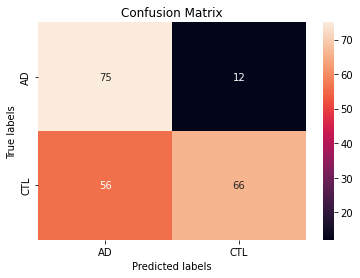

In [12]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test_encoded,y_pred_,labels=[1,0])
print('Classification report : \n',matrix)

labels = ['AD','CTL']
ax= plt.subplot()

# confusion matrix
matrix = confusion_matrix(
    y_test_encoded, y_pred_)

sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);



dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


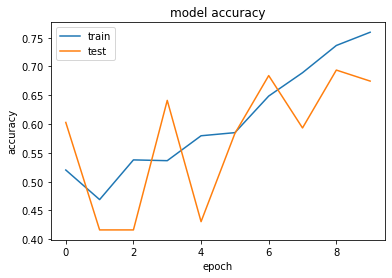

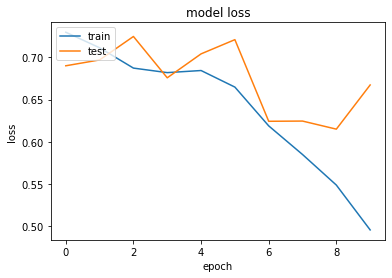

In [13]:
print("\n")
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# AUC - ROC

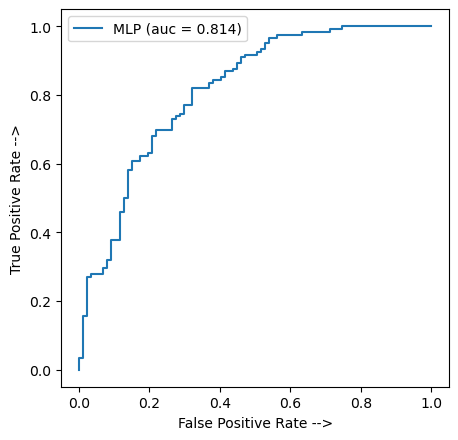

In [14]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test_encoded, y_pred[:,1])
auc_mlp = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle = '-', label = 'MLP (auc = %0.3f)' % auc_mlp)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

# Model Save

In [15]:
model.save("C:/Users/norma/Desktop/src/MLP.h5")

# Load Model

In [20]:
mlp_model = tf.keras.models.load_model("C:/Users/norma/Desktop/src/MLP.h5")

In [21]:
y_pred_load = mlp_model.predict(x_test)

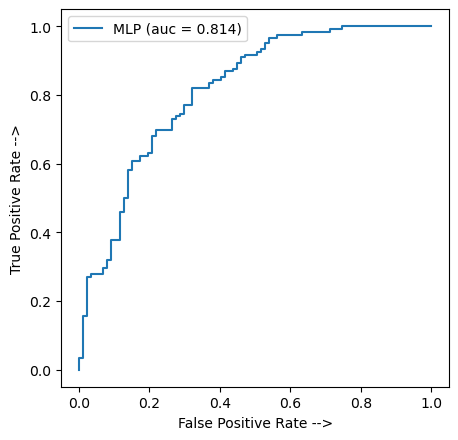

In [22]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test_encoded, y_pred_load[:,1])
auc_mlp = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle = '-', label = 'MLP (auc = %0.3f)' % auc_mlp)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()